In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: Cascade


In [2]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [3]:
import matplotlib.pyplot as plt

import numpy as np
# import torch

In [4]:
import scipy.io
import scipy.interpolate

import sklearn

from tqdm.notebook import tqdm

import copy
import time
import gc

In [5]:
dir_github = '/media/rich/Home_Linux_partition/github_repos/'

import sys
# sys.path.append('/n/data1/hms/neurobio/sabatini/rich/github_repos/')
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import ca2p_preprocessing, timeSeries, math_functions, indexing

%load_ext autoreload
%autoreload 2
from NBAP import import_data, align_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import cascade2p
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

	YAML reader installed (version 0.16.12).


2022-05-24 00:03:50.744815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


	Keras installed (version 2.4.0).
	Tensorflow installed (version 2.4.1).


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/Cascade/lib/python3.7/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [7]:
from pathlib import Path
import yaml

In [8]:
from pathlib import Path

# dir_S2p = Path(r'/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/')

In [9]:
dir_batch = ['/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0',
#              '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/exp/suite2p/plane0/',
#              '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/exp/suite2p/plane0/',
#              '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/exp/suite2p/plane0/',
#              '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/exp/suite2p/plane0/',
#              '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/exp/suite2p/plane0/',
#              '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/exp/suite2p/plane0/',
#              '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/exp/suite2p/plane0/',
#              '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/exp/suite2p/plane0/',
            ]

In [10]:
spike_prob_all = []
# for iter_day,dir_S2p in enumerate(dir_batch):
dir_S2p = dir_batch[0]

F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_S2p)

channelOffset_correction = 150
percentile_baseline = 10

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(   F=F + channelOffset_correction,
                                                                    Fneu=Fneu + channelOffset_correction,
                                                                    neuropil_fraction=0.7,
                                                                    percentile_baseline=percentile_baseline,
                                                                    multicore_pref=True,
                                                                    verbose=True)

dFoF_smooth = timeSeries.convolve_along_axis(dFoF,
                                            kernel=math_functions.gaussian(np.arange(-15,15), 0, sig=50/30, plot_pref=False),
                                            axis=1,
                                            mode='same',
                                            multicore_pref=True,
                                            verbose=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Calculated dFoF. Total elapsed time: 15.04 seconds
ThreadPool elapsed time : 1.3 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 2.21 seconds


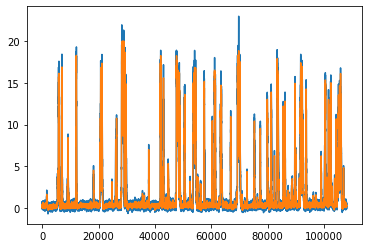

In [11]:
plt.figure()
plt.plot(dFoF[0])
plt.plot(dFoF_smooth[0])

In [12]:
cascade.download_model('update_models', model_folder=str(Path(dir_github) / 'Cascade' / 'Pretrained_models'),verbose = 1)

You can now check the updated available_models.yaml file for valid model names.
File location: /media/rich/Home_Linux_partition/github_repos/Cascade/Pretrained_models/available_models.yaml


In [13]:
yaml_file = open(str(Path(dir_github) / 'Cascade' / 'Pretrained_models' / 'available_models.yaml'))
X = yaml.load(yaml_file, Loader=yaml.Loader)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
    print(model)


 List of available models: 

Global_EXC_30Hz_smoothing50ms_asymmetric_window_1_frame
Global_EXC_30Hz_smoothing50ms_asymmetric_window_2_frames
Global_EXC_30Hz_smoothing50ms_asymmetric_window_4_frames
Global_EXC_30Hz_smoothing50ms_asymmetric_window_6_frames
Global_EXC_30Hz_smoothing50ms_asymmetric_window_8_frames
GCaMP6f_mouse_30Hz_smoothing200ms
OGB_zf_pDp_7.5Hz_smoothing200ms
OGB_zf_pDp_7.5Hz_smoothing200ms_causalkernel
Global_EXC_3Hz_smoothing400ms
Global_EXC_3Hz_smoothing400ms_causalkernel
Global_EXC_4.25Hz_smoothing300ms
Global_EXC_4.25Hz_smoothing300ms_causalkernel
Global_EXC_5Hz_smoothing200ms
Global_EXC_5Hz_smoothing200ms_causalkernel
Global_EXC_6Hz_smoothing200ms
Global_EXC_6Hz_smoothing200ms_causalkernel
Global_EXC_7.5Hz_smoothing200ms
Global_EXC_7.5Hz_smoothing200ms_causalkernel
Global_EXC_10Hz_smoothing100ms
Global_EXC_10Hz_smoothing100ms_causalkernel
Global_EXC_10Hz_smoothing200ms
Global_EXC_10Hz_smoothing200ms_causalkernel
Global_EXC_12.5Hz_smoothing100ms
Global_EXC_12.5Hz

In [13]:
spike_prob = np.concatenate([cascade.predict(model_name='Global_EXC_30Hz_smoothing50ms_causalkernel',
                                             traces=batch, 
#                                              model_folder='/n/data1/hms/neurobio/sabatini/rich/github_repos/Cascade/Pretrained_models', 
                                             model_folder='/media/rich/Home_Linux_partition/github_repos/Cascade/Pretrained_models', 
                                             padding=0
                                            ) for batch in indexing.make_batches(dFoF_smooth, num_batches=20)], axis=0)



 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 244 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.0, 0.0

Predictions for noise level 2:


2022-05-23 21:46:47.492319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-23 21:46:47.528096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.67GiB deviceMemoryBandwidth: 871.81GiB/s
2022-05-23 21:46:47.528145: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-23 21:46:47.530810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-23 21:46:47.530882: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-05-23 21:46:47.532456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

	... ensemble 0


2022-05-23 21:53:02.514293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-23 21:53:02.754788: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-23 21:54:25.307644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-23 22:08:33.227656: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-23 22:08:33.227808: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

2022-05-23 22:08:40.320165: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



  67/3217 [..............................] - ETA: 7s   

2022-05-23 22:08:40.608237: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



3199/3217 [============================>.] - ETA: 0s

2022-05-23 22:08:48.108027: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-23 22:08:48.416037: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-23 22:08:48.728079: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-23 22:08:49.035115: W tensorflow/stream_executor/gpu/

3217/3217 [==============================] - 953s 5ms/step


2022-05-23 22:08:55.745244: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



	... ensemble 1
3217/3217 [==============================] - 8s 2ms/step
	... ensemble 2
3217/3217 [==============================] - 7s 2ms/step
	... ensemble 3
3217/3217 [==============================] - 8s 2ms/step
	... ensemble 4
3217/3217 [==============================] - 8s 2ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argume

Noise levels (mean, std; in standard units): 0.0, 0.0

Predictions for noise level 2:
	... ensemble 0
3217/3217 [==============================] - 7s 2ms/step
	... ensemble 1
3217/3217 [==============================] - 8s 2ms/step
	... ensemble 2
3217/3217 [==============================] - 8s 2ms/step
	... ensemble 3
3217/3217 [==============================] - 8s 2ms/step
	... ensemble 4
3217/3217 [==============================] - 7s 2ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resample

Noise levels (mean, std; in standard units): 0.0, 0.0

Predictions for noise level 2:
	... ensemble 0
3217/3217 [==============================] - 8s 2ms/step
	... ensemble 1
3217/3217 [==============================] - 7s 2ms/step
	... ensemble 2
3217/3217 [==============================] - 8s 2ms/step
	... ensemble 3
3217/3217 [==============================] - 8s 2ms/step
	... ensemble 4
3217/3217 [==============================] - 8s 2ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Spike rate inference done.

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resample

2022-05-23 22:38:52.625241: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-23 22:38:53.712122: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-23 22:38:54.791519: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-23 22:38:55.875263: W tensorflow/stream_executor/gpu/

3085/3085 [==============================] - 35s 11ms/step


2022-05-23 22:39:19.553759: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



	... ensemble 1
3085/3085 [==============================] - 7s 2ms/step
	... ensemble 2
3085/3085 [==============================] - 7s 2ms/step
	... ensemble 3
3085/3085 [==============================] - 7s 2ms/step
	... ensemble 4
3085/3085 [==============================] - 7s 2ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Spike rate inference done.


In [14]:
test = cascade.predict(
    model_name='Global_EXC_30Hz_smoothing50ms_causalkernel',
    traces=dFoF_smooth[10, :5000][None,:], 
    model_folder='/media/rich/Home_Linux_partition/github_repos/Cascade/Pretrained_models', 
    padding=0
)



 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 1 neurons and 5000 frames.
Noise levels (mean, std; in standard units): 0.62, 0.0

Predictions for noise level 2:


2022-05-24 00:05:21.431419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-24 00:05:21.463342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.67GiB deviceMemoryBandwidth: 871.81GiB/s
2022-05-24 00:05:21.463425: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-24 00:05:21.466480: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-24 00:05:21.466535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-05-24 00:05:21.468123: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

	... ensemble 0


2022-05-24 00:11:28.042596: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-24 00:11:28.118526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-24 00:12:50.940765: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-24 00:27:27.427382: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-05-24 00:27:27.427616: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

2022-05-24 00:27:33.987994: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



1/1 [==============================] - 966s 966s/step
	... ensemble 1
1/1 [==============================] - 0s 64ms/step
	... ensemble 2
1/1 [==============================] - 0s 65ms/step


2022-05-24 00:27:34.257324: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



	... ensemble 3
1/1 [==============================] - 0s 63ms/step
	... ensemble 4
1/1 [==============================] - 0s 68ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Spike rate inference done.


<IPython.core.display.Javascript object>


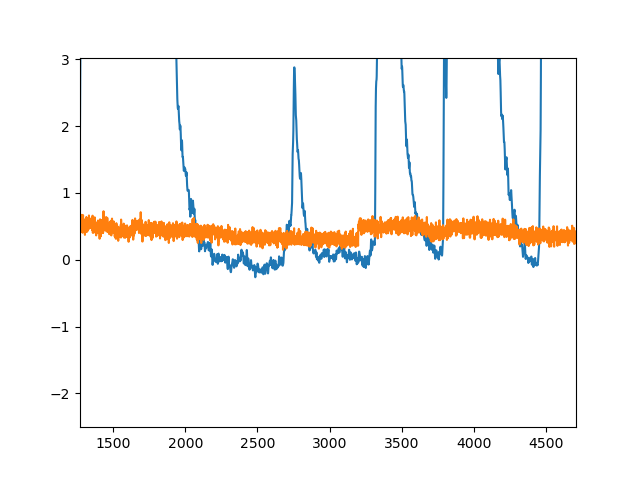

In [18]:
%matplotlib notebook

plt.figure()
plt.plot(dFoF_smooth[10, :5000])
plt.plot(test[0])

<IPython.core.display.Javascript object>


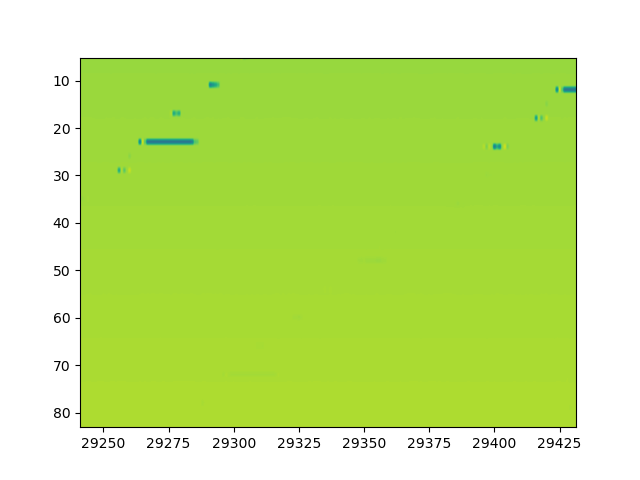

In [17]:
%matplotlib notebook
plt.figure()
plt.imshow(spike_prob[:100], aspect='auto')